This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        4
        inequality constraints with only lower bounds:        2
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        2

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5519537e+02 0.00e+00 1.57e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

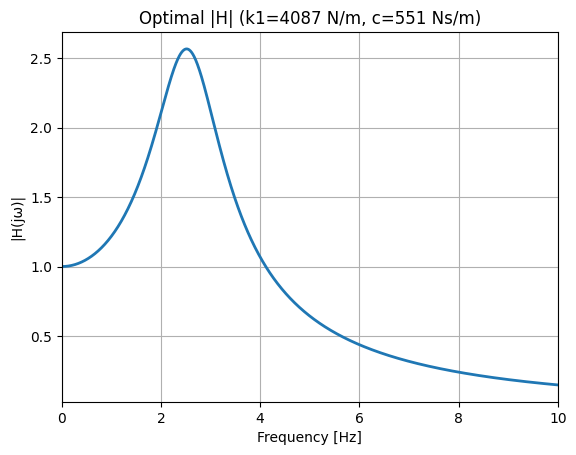

In [14]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt

# -----------------------
# Constants
# -----------------------

m1 = 25.0
m2 = 5.0
k2 = 15000.0
g  = 9.81

delta_x1_lim = 0.05  # 5 cm
delta_x2_lim = 0.02  # 2 cm

# delta_x2 = (m1+m2) g / k2  <= delta_x2_lim
delta_x2_static = (m1 + m2) * g / k2
if delta_x2_static > delta_x2_lim + 1e-12:
    raise ValueError(
        f"delta_x2 static constraint violated: {(delta_x2_static*100):.3f} cm > {(delta_x2_lim*100):.3f} cm"
    )

# delta_x1 = delta_x2 + m1 g / (2 k1) <= delta_x1_lim  -> k1 >= m1 g / (2*(dx1_lim - dx2_lim))
k1_min = m1*g/(2.0*(delta_x1_lim - delta_x2_lim)) 
k1_max = 40000.0

c_min = 1.0
c_max = 10000.0

# -----------------------
# Frequency grid (0...10 Hz)
# -----------------------

f_min, f_max = 0.0, 10.0
Nw = 1200  # Increase for more frequency points

f = np.linspace(f_min, f_max, Nw)
w = 2.0*np.pi*f  # rad/s

# Trapezoidal weights for integral over omega
dw = w[1] - w[0]
weights = np.ones(Nw)*dw
weights[0] *= 0.5
weights[-1] *= 0.5

# -----------------------
# CasADi Opti problem
# -----------------------

opti = ca.Opti()

k1 = opti.variable()
c  = opti.variable()

# Constraints
opti.subject_to(k1 >= k1_min)
opti.subject_to(k1 <= k1_max)
opti.subject_to(c  >= c_min)
opti.subject_to(c  <= c_max)

# Initial guesses
opti.set_initial(k1, max(8000.0, k1_min))
opti.set_initial(c,  1500.0)

J = 0
for wi, wt in zip(w, weights):

    # Numerator magnitude squared
    Nabs2 = (k2*c*wi)**2 + (2*k1*k2)**2

    # Denominator real/imag parts

    D_real = (2.0*k1 - m1*wi**2)*(2.0*k1 + k2 - m2*wi**2) - (2.0*k1)**2
    D_imaginary = c*wi*(k2 - (m1 + m2)*wi**2)

    Dabs2 = D_real**2 + D_imaginary**2

    Hij_abs2 = Nabs2 / Dabs2
    J = J + wt * Hij_abs2

opti.minimize(J)

# -----------------------
# IPOPT options
# -----------------------
opti.solver(
    "ipopt",
    {"print_time": False},
    {
        "print_level": 5,
        "max_iter": 2000,
        "tol": 1e-9,
    },
)

# -----------------------
# Solve
# -----------------------
sol = opti.solve()

k1_opt = float(sol.value(k1))
c_opt  = float(sol.value(c))
J_opt  = float(sol.value(J))

print(f"Static delta_x2 = {delta_x2_static*100:.3f} cm")
print(f"k1_min (from static constraint) = {k1_min:.2f} N/m")
print(f"Optimal k1 = {k1_opt:.3f} N/m")
print(f"Optimal  c = {c_opt:.3f} Ns/m")
print(f"Objective J = {J_opt:.6e}")

# -----------------------
# Plot optimal |H(jw)|
# -----------------------

Habs = np.zeros_like(w)
for idx, wi in enumerate(w):

    Nabs2 = (k2 * 2.0 * k1_opt)**2 + (k2 * c_opt * wi)**2

    D_real = (2.0 * k1_opt - m1 * wi**2)*(2.0 * k1_opt + k2 - m2 * wi**2) - (2.0 * k1_opt)**2
    D_imaginary = c_opt * wi * (k2 - (m1 + m2) * wi**2)
    Dabs2 = D_real**2 + D_imaginary**2

    Habs[idx] = np.sqrt(Nabs2 / Dabs2)

plt.figure()
plt.plot(f, Habs, linewidth=2)
plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(jω)|")
plt.title(f"Optimal |H| (k1={k1_opt:.0f} N/m, c={c_opt:.0f} Ns/m)")
plt.grid(True)
plt.xlim([0, 10])
plt.show()

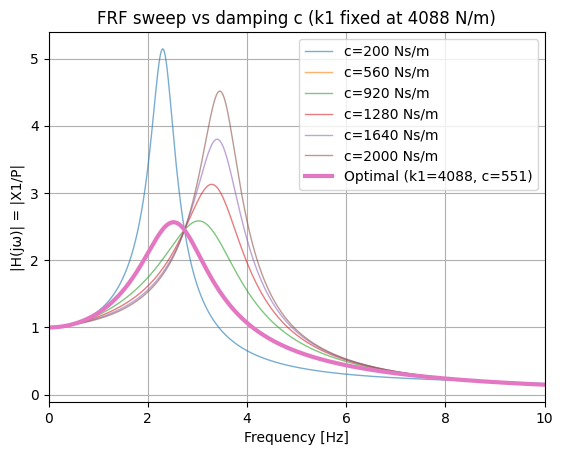

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import control as ct

m1 = 25.0
m2 = 5.0
k2 = 15000.0

k1_opt = 4087.500  # Optimal value calculated in previous question
c_opt  = 551.494   # Optimal value calculated in previous question

f = np.linspace(0, 10, 2000)
w = 2*np.pi*f

def H_tf(k1, c):
    s = ct.TransferFunction([1, 0], [1])
    N = k2*(c*s + 2*k1)
    D = (m2*s**2 + c*s + 2*k1 + k2)*(m1*s**2 + c*s + 2*k1) - (c*s + 2*k1)**2
    return N / D

k1_fixed = k1_opt
c_sweep = np.linspace(200, 2000, 6)

plt.figure()

for c in c_sweep:
    H = H_tf(k1_fixed, c)
    mag, phase, omega = ct.freqresp(H, w)
    mag = np.squeeze(mag)
    plt.plot(f, mag, linewidth=1, alpha=0.6, label=f"c={c:.0f} Ns/m")

H_best = H_tf(k1_opt, c_opt)
mag_best, phase_best, omega_best = ct.freqresp(H_best, w)
mag_best = np.squeeze(mag_best)
plt.plot(f, mag_best, linewidth=3, label=f"Optimal (k1={k1_opt:.0f}, c={c_opt:.0f})")

plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(jω)| = |X1/P|")
plt.title(f"FRF sweep vs damping c (k1 fixed at {k1_fixed:.0f} N/m)")
plt.grid(True)
plt.xlim([0, 10])
plt.legend()
plt.show()


Using relaxed dx2_lim = 3.60 cm (minimum needed for m1=50)
This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       33
Number of nonzeros in Lagrangian Hessian.............:        3

Total number of variables............................:        3
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       19
        inequality constraints with only lower bounds:        3
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       16

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e+0

c:\Users\justi\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\control\lti.py:646: FutureWarning: freqresp() is deprecated; use frequency_response()
  warn("freqresp() is deprecated; use frequency_response()", FutureWarning)


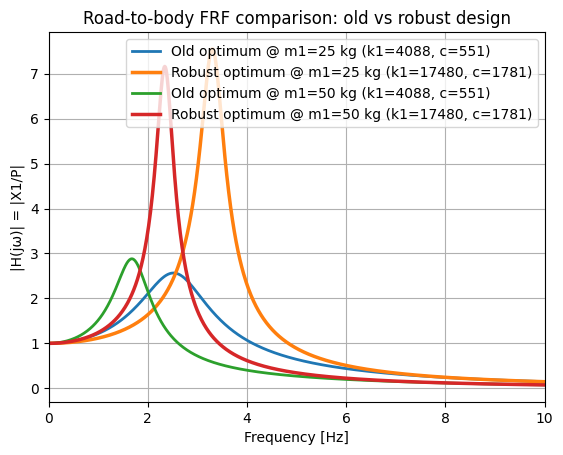

Robust optimal k1 = 17480.39 N/m
Robust optimal  c = 1781.13 Ns/m
Worst-case objective t = 2.682028e+02


In [20]:
import numpy as np
import casadi as ca
import control as ct

m2 = 5.0
k2 = 15000.0
g  = 9.81

dx1_lim = 0.05          # keep
m1_min, m1_max = 25.0, 50.0

# Minimal necessary relaxation for dx2 when m1 can be 50 kg
dx2_lim = (m1_max + m2)*g/k2   # ~0.03597 m

# (Optional) show what changed
print(f"Using relaxed dx2_lim = {dx2_lim*100:.2f} cm (minimum needed for m1=50)")

# Decision bounds
k1_min_bound = 1.0
k1_max_bound = 40000.0
c_min, c_max = 1.0, 10000.0

# Mass samples
Nm = 7
m1_grid = np.linspace(m1_min, m1_max, Nm)

# Frequency grid
f = np.linspace(0, 10, 800)     # start 800 for speed; increase later if you want
w = 2*np.pi*f
dw = w[1] - w[0]
weights = np.ones_like(w) * dw
weights[0] *= 0.5
weights[-1] *= 0.5

opti = ca.Opti()
k1 = opti.variable()
c  = opti.variable()
t  = opti.variable()   # epigraph for minimax

opti.subject_to([k1 >= k1_min_bound, k1 <= k1_max_bound])
opti.subject_to([c  >= c_min,        c  <= c_max])
opti.subject_to(t >= 0)

opti.set_initial(k1, 20000.0)
opti.set_initial(c,  2000.0)
opti.set_initial(t,  1.0)

def J_band(m1_val):
    a = 2.0*k1
    J = 0
    for wi, wt in zip(w, weights):
        # |N|^2
        Nr = k2*a
        Ni = k2*c*wi
        Nabs2 = Nr**2 + Ni**2

        # Denominator parts
        x1 = a + k2 - m2*wi**2
        x2 = a      - m1_val*wi**2
        Dr = x1*x2 - a**2
        Di = c*wi*(k2 - (m1_val + m2)*wi**2)
        Dabs2 = Dr**2 + Di**2

        J += wt*(Nabs2/Dabs2)
    return J

# Robust constraints + minimax: satisfy dx1 for all masses, minimize worst-case J
for m1i in m1_grid:
    dx2 = (m1i + m2)*g/k2           # constant for this m1i
    dx1 = dx2 + (m1i*g)/(2.0*k1)    # depends on k1 -> valid Opti constraint

    opti.subject_to(dx1 <= dx1_lim)

    Ji = J_band(m1i)
    opti.subject_to(t >= Ji)

opti.minimize(t)

opti.solver("ipopt",
            {"print_time": False},
            {"print_level": 5, "max_iter": 2000, "tol": 1e-9})

sol = opti.solve()

k1_rob = float(sol.value(k1))
c_rob  = float(sol.value(c))
t_rob  = float(sol.value(t))


masses = [25.0, 50.0]
k1_old = 4087.500
c_old = 551.494

def H_tf(m1, k1, c):
    s = ct.TransferFunction([1, 0], [1])
    N = k2*(c*s + 2*k1)
    D = (m2*s**2 + c*s + 2*k1 + k2)*(m1*s**2 + c*s + 2*k1) - (c*s + 2*k1)**2
    return N / D

def mag_H(m1, k1, c):
    H = H_tf(m1, k1, c)
    mag, phase, omega = ct.freqresp(H, w)  # your version returns 3 outputs
    return np.squeeze(mag)

plt.figure()

for m1 in masses:
    mag_old = mag_H(m1, k1_old, c_old)
    mag_new = mag_H(m1, k1_rob, c_rob)

    plt.plot(f, mag_old, linewidth=2,
             label=f"Old optimum @ m1={m1:.0f} kg (k1={k1_old:.0f}, c={c_old:.0f})")
    plt.plot(f, mag_new, linewidth=2.5,
             label=f"Robust optimum @ m1={m1:.0f} kg (k1={k1_rob:.0f}, c={c_rob:.0f})")

plt.xlabel("Frequency [Hz]")
plt.ylabel("|H(jω)| = |X1/P|")
plt.title("Road-to-body FRF comparison: old vs robust design")
plt.grid(True)
plt.xlim([0, 10])
plt.legend()
plt.show()

print(f"Robust optimal k1 = {k1_rob:.2f} N/m")
print(f"Robust optimal  c = {c_rob:.2f} Ns/m")
print(f"Worst-case objective t = {t_rob:.6e}")
